In [1]:
import hklearn 
from hklearn import Stack, ModelSet
import joblib
import matplotlib.pyplot as plt
import numpy as np
from hklearn.transforms import LogRatioScaler
import hylite
import pandas as pd
from hycore import loadShed
from sklearn.metrics import r2_score
import os
from matplotlib.colorbar import Colorbar
from matplotlib.transforms import Bbox
import dill
from sklearn.base import clone
import shap

In [21]:
#setup figure styles
import matplotlib as mpl
plt.style.use(['default'])
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
dipcmap = plt.get_cmap("RdYlGn_r")

### Load stack

Load the Stack object containing our data, and the associated dictionary of spectral indices and sample properties.

In [3]:
S = Stack.load('volcanoes.stack')
with open('indices.dill', 'rb') as f:
    indices = dill.load(f)

### Load modelset

In [4]:
# load univariate models
M = ModelSet.load("best_models.set")

In [5]:
# get model
#model = M.models['ensemble']

### Shapley values

To better understand the importance of the input features to each of these machine learning models, we now use SHAP to compute the renound Shapley values. These can help us understand what spectral features led to high or low predictions for each property.

In [6]:
from hklearn.estimators.ensemble import EnsembleEstimator

In [7]:
# select a fold to compute SHAP values for
fid = 1
folds = [v for k,v in S.subsets.items() if 'fold' in k]

test_ix = folds[fid]
train_ix = ~test_ix

test_X = S.X(transform=False)[test_ix,:]
train_X = S.X(transform=False)[train_ix,:]

In [8]:
# gather models for which the specified fold was the "test" data
models = []
for k,v in M.models.items():
    if 'mlp' in k.lower(): # ignore SVR model
        m = v.models[fid]
        models.append(m)
    
# build a single ensemble estimator
est = EnsembleEstimator( models, combination_method='average', n_jobs=len(models) )

In [9]:
# build a predict function that wraps our PCA transforms into the model predictions
def predict( X ):
    # split X back into each sensor
    sensors = ['FENIX', 'FX50', 'LWIR']
    nbands = [S.X(n).shape[-1] for n in sensors]
    split = [X[:, sum(nbands[:i]):sum(nbands[:i+1])] for i in range(3)]
    
    # apply PCAs
    for i in range(3):
        split[i] = S.transforms[sensors[i]].transform(split[i])
    Xt = S.transforms['all'].transform( np.hstack(split) )
    
    # pass on to our model and return the result
    return est.predict( Xt )

# sanity check -- our predict function should give the same results as model.predict with transformed data
assert np.sum( np.abs( predict( test_X ) - est.predict( S.X(transform=True)[test_ix, : ] ) )) < 1e-6

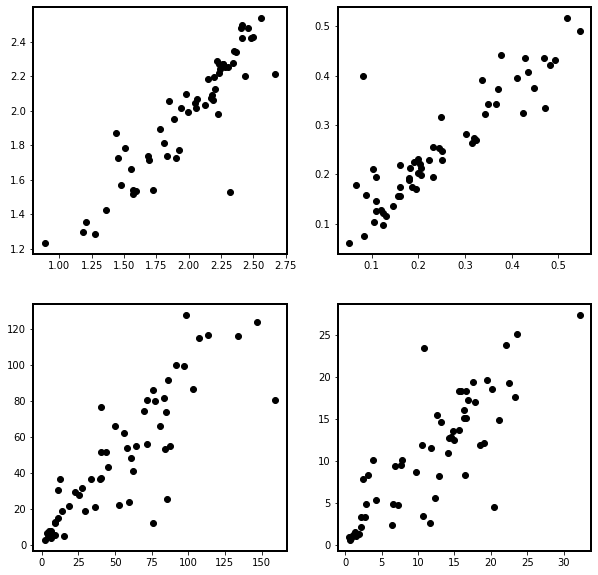

In [10]:
# check that scatter plot looks ok
y_pred = predict( test_X )
y_true = S.y()[ test_ix ]
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,a in enumerate( ax.ravel() ):
    a.scatter( y_true[:,i], y_pred[:,i], color='k' )

In [10]:
import dill
if False:
    from tqdm import tqdm # import non-notebook tqdm version
    import shap.explainers._kernel 
    shap.explainers._kernel.tqdm = tqdm # monkey-patch --> set shap to use non-notebook tqdm (as the notebook one doesn't seem to work?)

    # construct an explainer
    explainer = shap.KernelExplainer(predict, shap.kmeans(train_X, 16) )

    # get the SHAP values (for each sample and output)
    shap_values = explainer.shap_values(test_X, nsamples='auto', gc_collect=True) # compute SHAP values the selected samples

    # save results coz computation is slooooow
    with open('shap_values2.dill','wb') as f:
        dill.dump( shap_values, f )
else:
    # load saved results
    with open('shap_values2.dill','rb') as f:
        shap_values = dill.load(f)

In [11]:
yp = predict( shap.kmeans(train_X, 16).data )

In [12]:
yhat = np.mean( yp, axis=0 )

In [13]:
# get predictions and ensemble errors for plotting
y_pred, std = est.predict( S.X(transform=True)[test_ix,:], variance_metric='std' )

In [14]:
# split shap values into individual sensors
sensors = ['FENIX', 'FX50', 'LWIR']
nbands = [S.X(n).shape[-1] for n in sensors]
split = [ [s[:, sum(nbands[:i]):sum(nbands[:i+1])] for i in range(3)] for s in shap_values ]
out = {'indices' : test_ix, 'input_features':test_X} # keep these for reproduction if needed
for i,s in enumerate(sensors):
    out[s] = [ s[i] for s in split ] 

### Plot

Make some nice plots of the SHAP values

In [15]:
# load indices for plotting
with open('indices.dill', 'rb') as f:
    spectral = dill.load(f)
hydration = spectral['hydration'][S.valid.squeeze()][test_ix] # get our hydration index values
vmin,vmax = np.nanpercentile( hydration, ( 5, 95 ) )

In [16]:
# define symbology for each volcano
symbols = {'Copahue':'d','Cracked Mountain':'^','Deception Island':'X','La Soufriere':'s','Ruapehu':'P',
     'Ohakuri':'o','Other':'.','Tongariro':'*','Volvic':'v','Whakaari':'p'}
sz = {'*':2.2,'d':1.5,'p':1.,'+':2, 's':0.8} # adjust default marker size so they are more perceptually uniform

ids = indices['sample_id'][ S.valid[:,0] ][test_ix] # sample IDS
volcs = indices['volcanoes'][ S.valid[:,0] ][test_ix] # volcano name


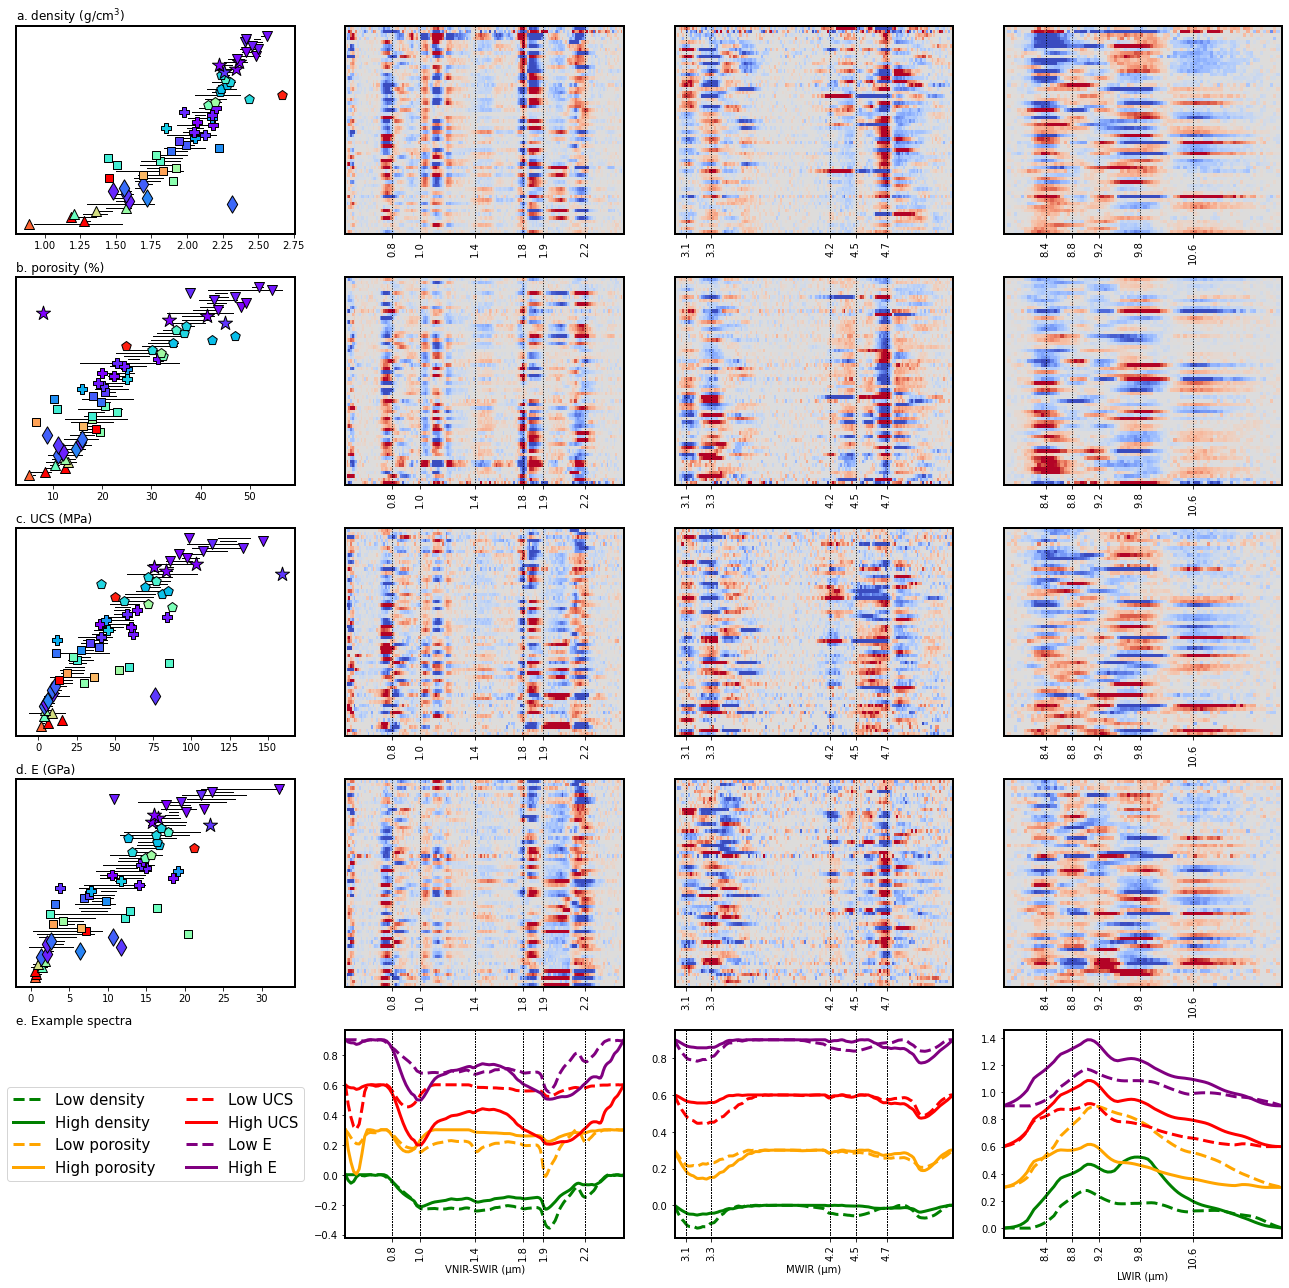

In [18]:
titles = ['a. density (g/cm$^3$)','b. porosity (%)','c. UCS (MPa)','d. E (GPa)']
sensors = ['FENIX','FX50','LWIR']
xlabels = ['VNIR-SWIR (μm)', 'MWIR (μm)', 'LWIR (μm)']

# compute min and max for SHAP vals
#smin, smax = np.nanpercentile( [out[s] for s in sensors], ( 2, 98 ) )

# setup figure layout
fig,ax = plt.subplots(len(titles)+1, len(sensors)+1, figsize=(18,18))
for i,t in enumerate(titles):
    ax[i,0].set_title(t,loc='left')
    ax[i,0].set_yticks([])
for j,s in enumerate(sensors):
    ax[-1,j+1].set_xlabel(xlabels[j])
    #ax[-1,j+1].set_yticks([])
    for i in range(len(titles)-1):
        ax[i,j+1].set_xticks([])
        ax[i,j+1].set_yticks([])

fig.tight_layout()

for i in range(4):
    # add scatter plots
    y_true = S.y()[test_ix, i]
    ixx = np.argsort( y_pred[:, i]) # sort by prediction magnitude
    for k in range(len(ixx)):
        # get volcano symbol
        _s = symbols.get(volcs[k], symbols['Other'])
        _sz = 100*sz.get(_s,1)
        
        sf = 1
        if i == 1:
            sf = 100 # convert porosity to percentages
        ax[i,0].scatter( y_true[ixx][k]*sf, k, c = hydration[k], marker=_s, s=_sz, 
                         vmin=vmin, vmax=vmax, cmap='rainbow',zorder=1, edgecolors='k' )
        ax[i,0].plot( [y_pred[ixx,i][k]*sf - 2*std[ixx,i][k]*sf, y_pred[ixx,i][k]*sf + 2*std[ixx,i][k]*sf ],
                      [k,k],
                      color='k', lw=1, zorder=0)

    # add SHAP values
    for j,s in enumerate(sensors):
        wav = S.get_wavelengths(s)
        vmx = np.percentile( out[s][i][ixx,: ], 98)
        ax[i,j+1].imshow( out[s][i][ixx,: ], aspect='auto', cmap='coolwarm', vmin=-vmx, vmax=vmx,
                          extent = (np.min(wav), np.max(wav), 0, len(ixx)), interpolation='none')
        fl = [800, 1000, 1400, 1750, 1900, 2200,
                  3100, 3300., 4250, 4450, 4700, 8400, 8800, 9200, 9800,10600]
        for w in fl:
            if (w > np.min(wav)) and (w < np.max(wav)):
                ax[i,j+1].axvline(w, color='k', ls=':', lw=1 )
        ax[i,j+1].set_xticks([w for w in fl if (w > np.min(wav)) and (w < np.max(wav))])
        ax[i,j+1].set_xticklabels(["%.1f"%(w/1000) for w in ax[i,j+1].get_xticks()], rotation=90)
        ax[i,j+1].set_yticks([])
        
# show low and high spectra
offset = 0
colors = ['green','orange', 'red', 'purple']
for j,n in enumerate( ['density', 'porosity', 'UCS', 'E'] ):
    vmn,vmx = np.percentile( y_pred[:,j], (2,98) ) # drop extrema as these are possibly nasty
    mask = (y_pred[:,j] > vmn) & (y_pred[:,j] < vmx)
    ix0 = np.argmin( y_pred[mask,j] ) # get spectra with the lowest predicted value
    ix1 = np.argmax( y_pred[mask,j] ) # get spectra with the highest predicted value
    
    ax[-1, 0].plot( [np.nan,np.nan], [np.nan,np.nan], lw=3, label="Low %s"%(n), ls='--', c=colors[j] ) # for the legend
    ax[-1, 0].plot( [np.nan,np.nan], [np.nan,np.nan], lw=3, label="High %s"%(n), ls='-',  c=colors[j]) # for the legend
    for i,s in enumerate(['FENIX', 'FX50', 'LWIR']):
        wav = S.get_wavelengths(s)
        ax[-1, 1+i].set_xlim( np.min(wav), np.max(wav) )
        for ix,style in zip( [ix0, ix1], ['--','-'] ):
            if i < 2:
                _y = 1 - S.X(s)[test_ix,:][mask,:][ix,:] #S.X(s)[ix,:] # undo inverse
            else:
                _y = S.X(s)[test_ix,:][mask,:][ix,:] #S.X(s)[ix,:]
            ax[-1, 1+i].plot( wav, _y - _y[0] + offset, label=k, lw=3, ls=style,  c=colors[j] )

            for w in fl:
                if (w > np.min(wav)) and (w < np.max(wav)):
                    ax[-1, 1+i].axvline(w, color='k', ls=':', lw=1 )
                    ax[-1, 1+i].set_xticks([w for w in fl if (w > np.min(wav)) and (w < np.max(wav))])
                    ax[-1, 1+i].set_xticklabels(["%.1f"%(w/1000) for w in ax[-1, 1+i].get_xticks()], rotation=90)
        
    offset += 0.3
ax[-1,0].set_xticks([])
ax[-1,0].set_yticks([])
ax[-1,0].legend(loc='center', prop={'size': 15}, ncol=2)

ax[-1,0].set_title("e. Example spectra", loc='left')
ax[-1,0].set_axis_off()

fig.tight_layout()

fig.savefig("shap.png", dpi=300)
fig.savefig("shap.svg", dpi=300)
fig.show()

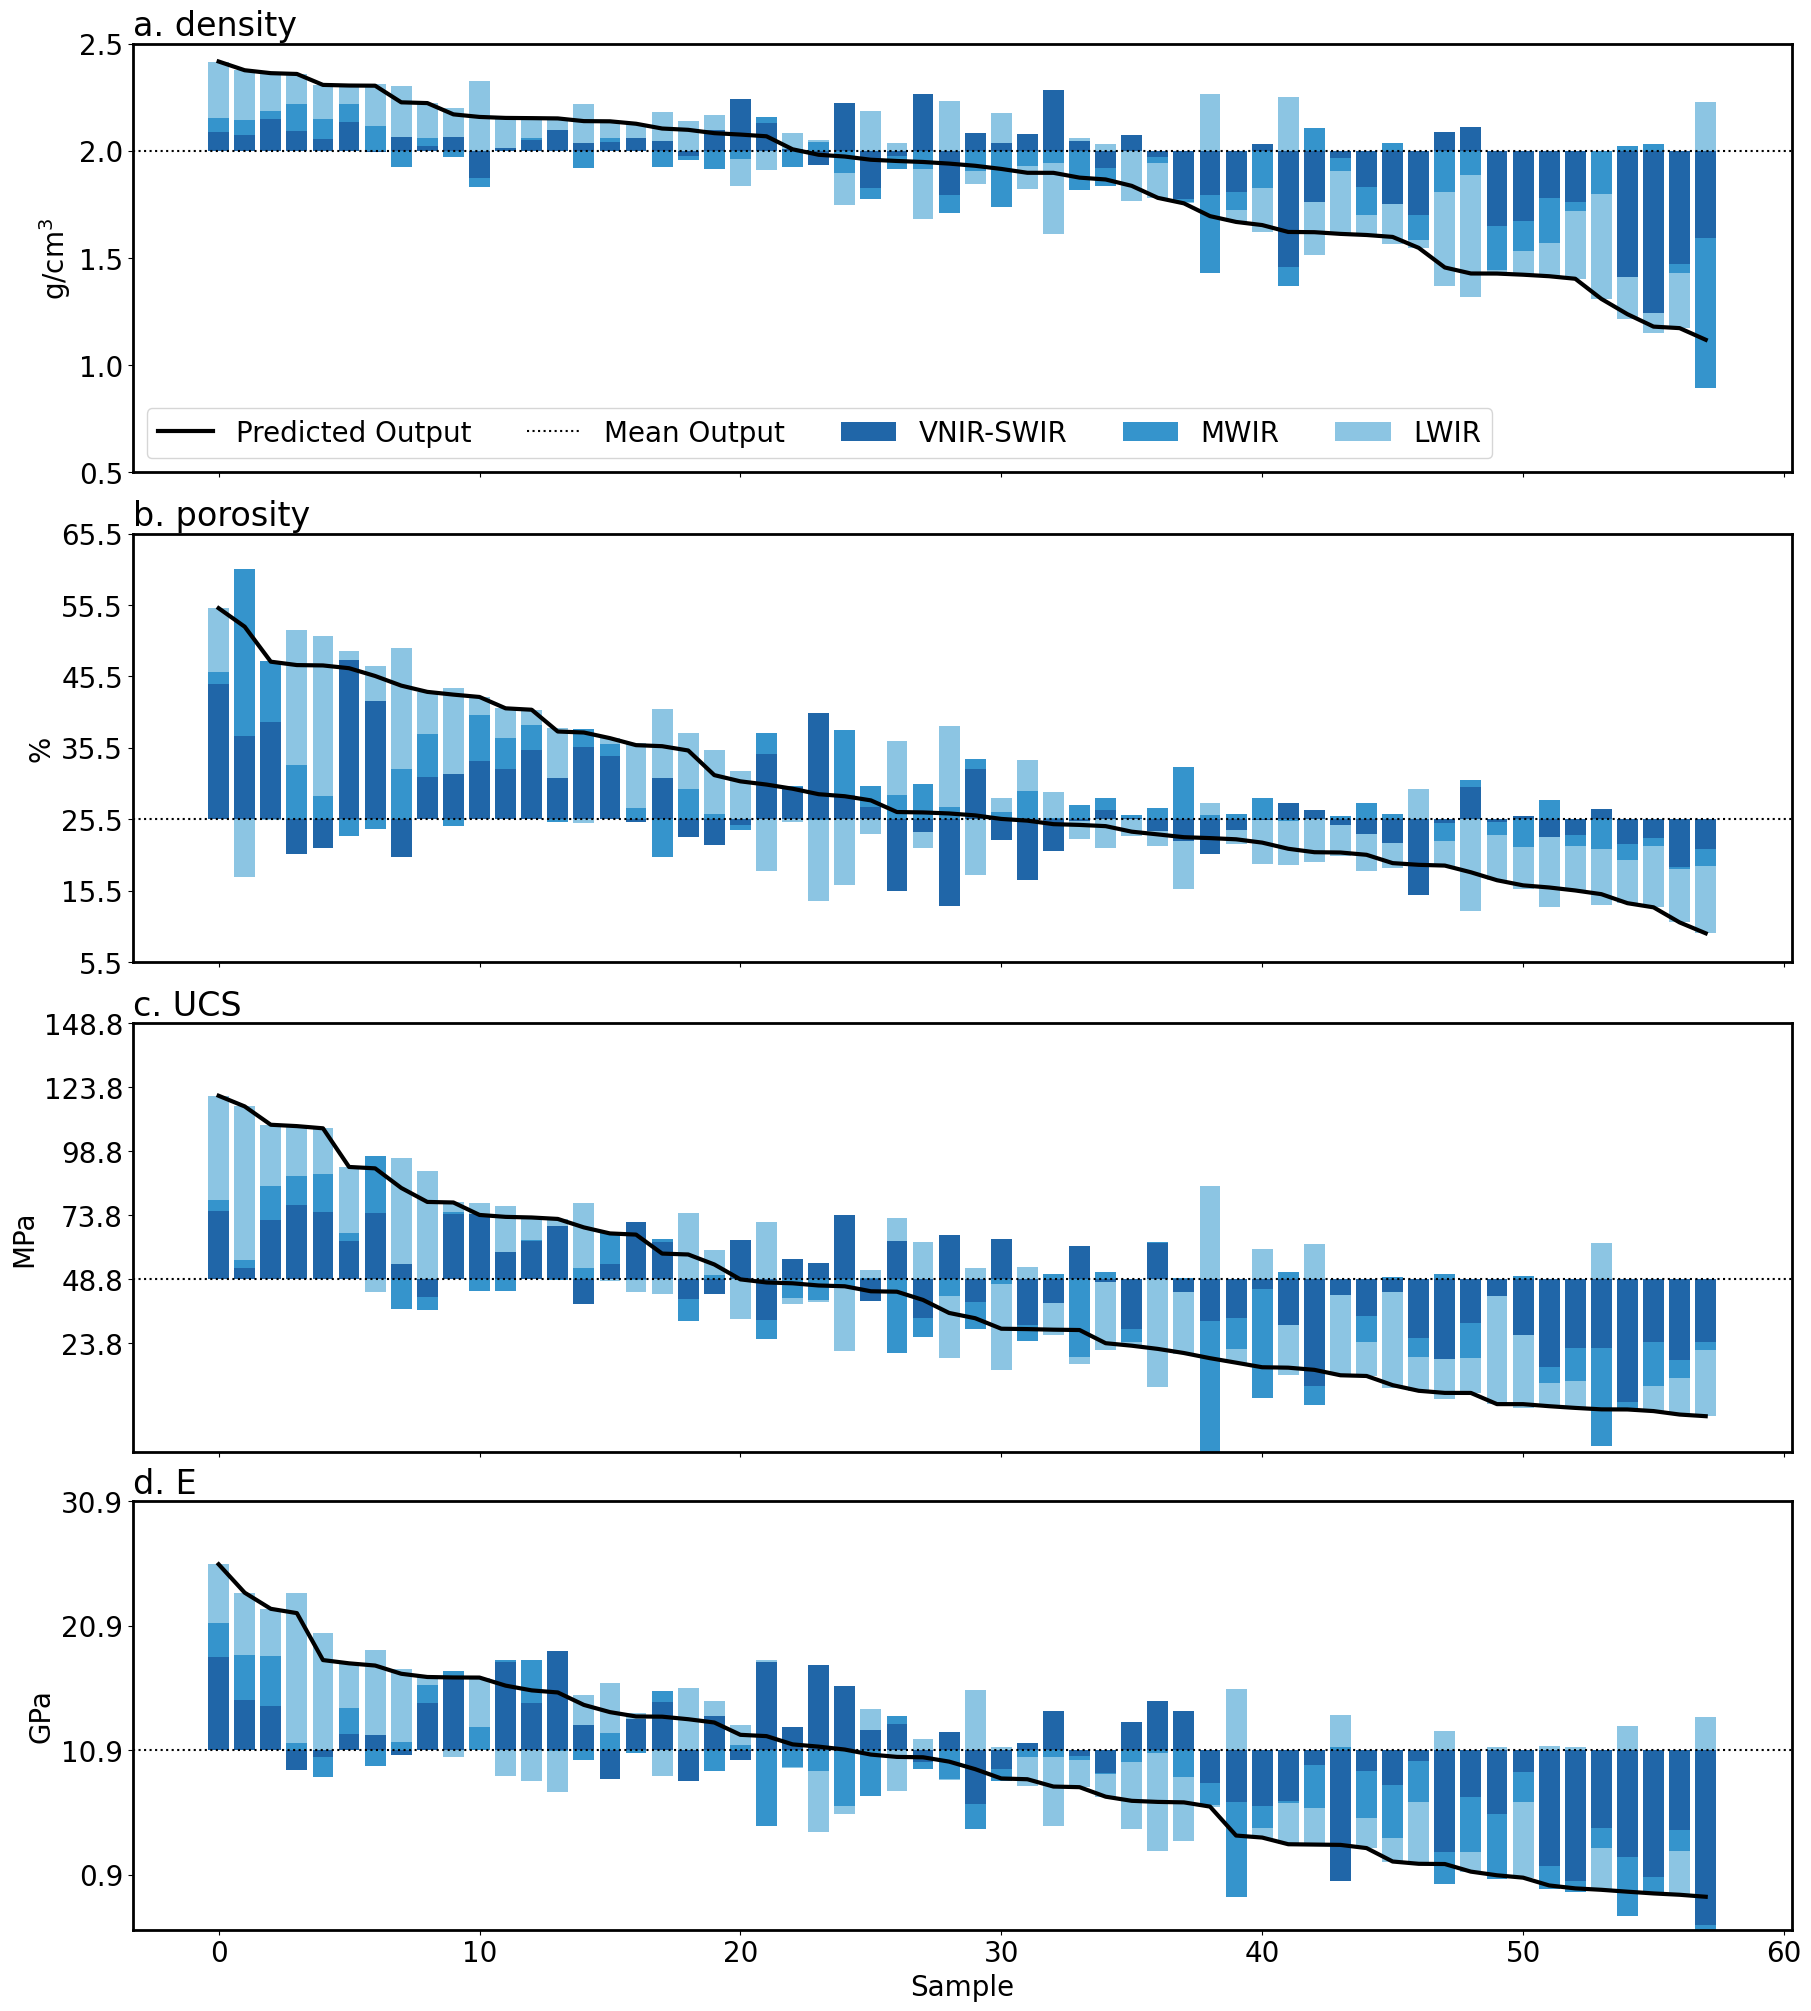

In [22]:
fig, ax = plt.subplots(4, 1, figsize=(18, 20), sharex=True, layout="constrained")
units =  ['g/cm$^3$','%','MPa','GPa']
labs = ['a. density','b. porosity','c. UCS','d. E']

sort_idx = np.argsort(y_pred, axis=0)[::-1]
mean = np.mean(y_pred, axis=0)
for i in range(4):
    
    norm_shap_swir = out['FENIX'][i][sort_idx[:, i]] #shaps[i][sort_idx[:, i], :413]
    norm_shap_mwir = out['FX50'][i][sort_idx[:, i]] #shaps[i][sort_idx[:, i], 413:413+289]
    norm_shap_lwir = out['LWIR'][i][sort_idx[:, i]] #shaps[i][sort_idx[:, i], 413+289:]

    swir_contr = norm_shap_swir.sum(axis=1)
    mwir_contr = norm_shap_mwir.sum(axis=1)
    lwir_contr = norm_shap_lwir.sum(axis=1)
    pred_from_contr = swir_contr + mwir_contr + lwir_contr
    
    swir_pos = swir_contr * (swir_contr >= 0)
    mwir_pos = mwir_contr * (mwir_contr >= 0)
    lwir_pos = lwir_contr * (lwir_contr >= 0)
    
    swir_neg = swir_contr * (swir_contr < 0)
    mwir_neg = mwir_contr * (mwir_contr < 0)
    lwir_neg = lwir_contr * (lwir_contr < 0)
    
    ns = len( swir_pos )  # number of samples
    sf = 1
    if i == 1:
        sf = 100
    #ax[i].stackplot( np.arange( ns), swir_pos*sf, mwir_pos*sf, lwir_pos*sf, colors=["#2066a8", "#3594cc", "#8cc5e3"], labels=["VNIR-SWIR", "MWIR", "LWIR"], edgecolor=None)
    #ax[i].stackplot( np.arange( ns), swir_neg*sf, mwir_neg*sf, lwir_neg*sf, colors=["#2066a8", "#3594cc", "#8cc5e3"], edgecolor=None)
    ax[i].bar(np.arange(ns), swir_pos*sf, color="#2066a8", label="VNIR-SWIR")
    ax[i].bar(np.arange(ns), mwir_pos*sf, bottom=swir_pos*sf, color="#3594cc", label="MWIR")
    ax[i].bar(np.arange(ns), lwir_pos*sf, bottom=(swir_pos+mwir_pos)*sf, color="#8cc5e3", label="LWIR")
    
    ax[i].bar(np.arange(ns), swir_neg*sf, color="#2066a8")
    ax[i].bar(np.arange(ns), mwir_neg*sf, bottom=swir_neg*sf, color="#3594cc")
    ax[i].bar(np.arange(ns), lwir_neg*sf, bottom=(swir_neg+mwir_neg)*sf, color="#8cc5e3")
    
    
    ax[i].plot( np.arange( ns), pred_from_contr*sf, "k", label="Predicted Output", lw=3)
    ax[i].axhline(0, c="k", linestyle="dotted", label="Mean Output")
        
    axticks = ax[i].get_yticks()
    ax[i].set_yticks([t for t in axticks if (t+mean[i]*sf) > 0], labels = ["%.1f" % val for val in (axticks + mean[i]*sf) if val > 0])
    ax[i].set_title(labs[i], loc="left")
    ax[i].set_ylabel(units[i])
    ax[i].set_title(labs[i], loc="left")

ax[0].legend(ncol=5)
ax[-1].set_xlabel("Sample")
    
fig.savefig("./figures/spectralRanges.png", dpi=300)
fig.savefig("./figures/spectralRanges.svg", dpi=300)
fig.show()